In [1]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, ReLU, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# 모델 정의
def build_advanced_srcnn():
    inputs = Input(shape=(FIXED_SIZE[0], FIXED_SIZE[1], 3))
    x = Conv2D(64, (6, 6), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, (3, 3), padding='same')(x)
    outputs = Add()([inputs, x])

    return Model(inputs, outputs)

In [ ]:
# 이미지 전처리 함수
def preprocess_pair_fixed(image_path, upscale_factor=2):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if img is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, FIXED_SIZE)

    lr = cv2.resize(img, (FIXED_SIZE[0] // upscale_factor, FIXED_SIZE[1] // upscale_factor), interpolation=cv2.INTER_CUBIC)
    lr = cv2.resize(lr, FIXED_SIZE, interpolation=cv2.INTER_CUBIC)

    lr = lr.astype(np.float32) / 255.0
    hr = img.astype(np.float32) / 255.0

    return lr, hr

In [ ]:
# Dataset 생성
def create_fixed_dataset(image_dir, batch_size=4):
    image_paths = glob(os.path.join(image_dir, "*.jpg"))

    def generator():
        for path in image_paths:
            try:
                lr, hr = preprocess_pair_fixed(path, 2)
                yield lr, hr
            except:
                continue

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(FIXED_SIZE[0], FIXED_SIZE[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(FIXED_SIZE[0], FIXED_SIZE[1], 3), dtype=tf.float32),
        )
    )

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# 테스트 이미지 전처리 함수
def preprocess_test_image(image_path, upscale_factor=2):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if img is None:
        raise ValueError("이미지를 불러올 수 없습니다.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, FIXED_SIZE)

    lr = cv2.resize(img, (FIXED_SIZE[0] // upscale_factor, FIXED_SIZE[1] // upscale_factor), interpolation=cv2.INTER_CUBIC)
    lr_up = cv2.resize(lr, FIXED_SIZE, interpolation=cv2.INTER_CUBIC)

    lr_up_norm = lr_up.astype(np.float32) / 255.0
    lr_up_norm = np.expand_dims(lr_up_norm, axis=0)

    return lr_up_norm, lr, img

In [11]:
# 업스케일링
def upscale_and_show(image_path):
    input_tensor, lr_img, hr_gt = preprocess_test_image(image_path)

    sr = model.predict(input_tensor)[0]
    sr = np.clip(sr * 255.0, 0, 255).astype(np.uint8)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_img)
    plt.title("Low-Res Input (Upscaled)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sr)
    plt.title("SRCNN Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(hr_gt)
    plt.title("Original High-Res")
    plt.axis('off')

    plt.show()

In [12]:
FIXED_SIZE = (128, 128)

image_dir = 'img'
dataset = create_fixed_dataset(image_dir)

model = build_advanced_srcnn()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_absolute_error')

model.fit(dataset, epochs=20)
model.save('srcnn.h5')

Epoch 1/20
5/5 [==============================] - 3s 363ms/step - loss: 0.5363
Epoch 2/20
5/5 [==============================] - 2s 305ms/step - loss: 0.4647
Epoch 3/20
5/5 [==============================] - 2s 306ms/step - loss: 0.4095
Epoch 4/20
5/5 [==============================] - 2s 353ms/step - loss: 0.3614
Epoch 5/20
5/5 [==============================] - 2s 302ms/step - loss: 0.3235
Epoch 6/20
5/5 [==============================] - 2s 313ms/step - loss: 0.2911
Epoch 7/20
5/5 [==============================] - 2s 333ms/step - loss: 0.2645
Epoch 8/20
5/5 [==============================] - 2s 316ms/step - loss: 0.2426
Epoch 9/20
5/5 [==============================] - 2s 315ms/step - loss: 0.2248
Epoch 10/20
5/5 [==============================] - 2s 314ms/step - loss: 0.2100
Epoch 11/20
5/5 [==============================] - 2s 311ms/step - loss: 0.1972
Epoch 12/20
5/5 [==============================] - 2s 335ms/step - loss: 0.1862
Epoch 13/20
5/5 [==============================] 

1/1 [==============================] - 0s 244ms/step


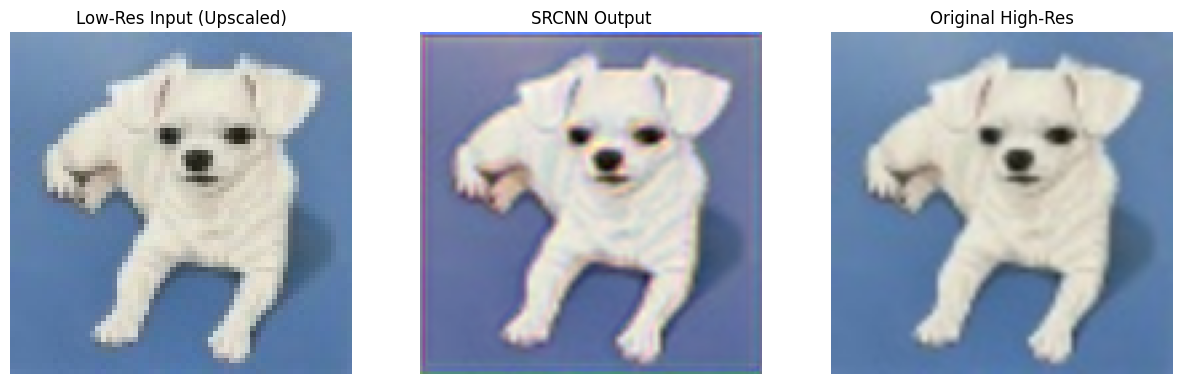

In [13]:
# model = tf.keras.models.load_model('srcnn.h5')

test_image_path = 'image2.jpg'

upscale_and_show(test_image_path)